In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config, preprocess
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (6, 6)

Using TensorFlow backend.


In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [17]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

In [18]:
gt = gt[2:-1]

In [19]:
gt[:, 1] = gt[:, 1] - 1

In [9]:
# re = RecordingExplorer(path_to_standarized, spike_size=15)
# se = SpikeTrainExplorer(gt, re)

In [20]:
min_amp = 5
nspikes = 50000
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [21]:
(x_detect,
 y_detect,
 x_triage,
 y_triage,
 x_ae,
 y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                            min_amp, nspikes,
                            data_folder='/home/Edu/data/nnet/')

INFO:yass.augment.make:Getting templates...
INFO:yass.templates.util:Computing templates...
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
100%|██████████| 113/113 [00:04<00:00, 25.13it/s]
INFO:yass.batch.batch:yass.templates.util.compute_weighted_templates took 4.4984 seconds
INFO:yass.augment.make:Got templates ndarray of shape: (49, 81, 49)
INFO:yass.augment.make:Good looking templates of shape: (18, 81, 49)


# Training

In [6]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001

## inspecting

In [7]:
CONFIG.channel_index.shape

(49, 19)

In [35]:
threshold = 0.5
channel_index = CONFIG.channel_index
waveform_length = 21
filters_size = 16, 26
n_neigh = 7

In [40]:
tf.squeeze?

In [36]:
import tensorflow as tf
from yass.neuralnetwork.utils import (weight_variable, bias_variable, conv2d,
                                      conv2d_VALID, max_pool)


small_channel_index = channel_index[:, :n_neigh]
x_tf = tf.placeholder("float", [None, None])
T = tf.shape(x_tf)[0]

print('T', T, 'K2', K2)

x_cnn_tf = tf.expand_dims(tf.expand_dims(x_tf, -1), 0)

vars_dict, layer11 = NeuralNetDetector._make_network(x_cnn_tf,
                                       waveform_length,
                                       filters_size,
                                       n_neigh)

print('\nlayer11', layer11)

W2 = vars_dict['W2']
b2 = vars_dict['b2']

K1, K2 = filters_size

# first spatial layer
zero_added_layer11 = tf.concat((tf.transpose(layer11, [2, 0, 1, 3]),
                                tf.zeros((1, 1, T, K2))),
                               axis=0)

print('\nzero_added_layer11', zero_added_layer11)

temp = tf.transpose(tf.gather(zero_added_layer11, small_channel_index),
                    [0, 2, 3, 1, 4])

print('\ntemp', temp)

_ = [-1, T, n_neigh, K2]

temp2 = conv2d_VALID(tf.reshape(temp, _), W2) + b2

print('\ntemp2', temp2)

o_layer = tf.transpose(temp2, [2, 1, 0, 3])

print('\no_layer', o_layer)


T Tensor("strided_slice_10:0", shape=(), dtype=int32) K2 26

layer11 Tensor("Relu_27:0", shape=(1, ?, ?, 26), dtype=float32)

zero_added_layer11 Tensor("concat_9:0", shape=(?, 1, ?, 26), dtype=float32)

temp Tensor("transpose_26:0", shape=(49, 1, ?, 7, 26), dtype=float32)

temp2 Tensor("add_37:0", shape=(?, ?, 1, 1), dtype=float32)

o_layer Tensor("transpose_27:0", shape=(1, ?, ?, 1), dtype=float32)


In [37]:
# train code
x_train = x_detect
n_data, waveform_length_train, n_neigh_train = x_train.shape

# x and y input tensors
x_tf = tf.placeholder("float", [n_batch, waveform_length_train,
                                n_neigh_train])
y_tf = tf.placeholder("float", [n_batch])

input_tf = tf.expand_dims(x_tf, -1)

vars_dict, layer11 = NeuralNetDetector._make_network(input_tf,
                                       waveform_length_train,
                                       filters_size,
                                       n_neigh_train)

print('\nlayer11', layer11)

W2 = vars_dict['W2']
b2 = vars_dict['b2']

# third layer: spatial convolution
o_layer = tf.squeeze(conv2d_VALID(layer11, W2) + b2)

print('\no_layer', o_layer)        


layer11 Tensor("Relu_29:0", shape=(512, 21, 7, 26), dtype=float32)

o_layer Tensor("Squeeze_2:0", shape=(512, 21), dtype=float32)


## Detector training

In [13]:
import util

In [14]:
detectnet_name = path.join('models', 'detect-'+util.directory()+'.ckpt')
n_filters_detect = [8, 4]

In [74]:
print(detectnet_name)

models/detect-26-Jun-2018@14-32-34.ckpt


In [75]:
NeuralNetDetector.train(x_detect, y_detect,
                        n_filters_detect, n_iter,
                        n_batch, l2_reg_scale,
                        train_step_size,
                        detectnet_name)

INFO:yass.neuralnetwork.model_detector:Training detector network...
12492501it [01:39, 253007.71it/s]                   INFO:yass.neuralnetwork.model_detector:Approximate training true positive rate: 1.0, false positive rate: 0.0
12502500it [01:39, 125249.96it/s]
INFO:yass.neuralnetwork.model_detector:Saving detector network parameters...


## Triage training

In [43]:
path_to_triage = path.join('models', 'triage-'+util.directory()+'.ckpt')
filters_triage = [8, 4]
_, waveform_length, n_neighbors = x_triage.shape

In [41]:
print(path_to_triage)

models/triage-26-Jun-2018@22-02-58.ckpt


(150012, 21, 7)

In [48]:
triage = NeuralNetTriage(path_to_triage, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=5000)
triage.fit(x_triage, y_triage)

INFO:yass.neuralnetwork.model_triage:Training triage network...

 95%|█████████▌| 4753/5000 [00:01<00:14, 17.35it/s]
5995it [00:01, 24.76it/s]                          
7381it [00:02, 35.35it/s]
8911it [00:02, 50.45it/s]
10585it [00:02, 71.97it/s]
12403it [00:02, 102.63it/s]
14365it [00:02, 146.28it/s]
16471it [00:02, 208.32it/s]
18721it [00:02, 296.38it/s]
21115it [00:02, 421.03it/s]
23653it [00:02, 596.95it/s]
26335it [00:02, 844.30it/s]
29161it [00:03, 1190.15it/s]
32131it [00:03, 1670.09it/s]
35245it [00:03, 2330.57it/s]
38503it [00:03, 3224.64it/s]
41905it [00:03, 4421.66it/s]
45451it [00:03, 5985.24it/s]
49141it [00:03, 7962.67it/s]
52975it [00:03, 10395.56it/s]
56953it [00:03, 13279.99it/s]
61075it [00:04, 16626.98it/s]
65341it [00:04, 20184.85it/s]
69751it [00:04, 23847.61it/s]
74305it [00:04, 27638.42it/s]
79003it [00:04, 31259.52it/s]
83845it [00:04, 34523.27it/s]
88831it [00:04, 37546.63it/s]
93961it [00:04, 40262.38it/s]
99235it [00:04, 42680.98it/s]
104653it [00:04, 45222.

TypeError: save_triage_network_params() got an unexpected keyword argument 'waveform_length'

In [49]:
waveform[:, :, :7].shape

(226578, 21, 7)

In [39]:
triage.predict(waveform)

array([ True, False, False, ...,  True,  True, False])

## Autoencoder training

In [29]:
ae_name = path.join('models', 'ae-'+util.directory()+'.ckpt')
n_features = 3
n_batch = 1024
n_iter = 10000
train_step_size =  0.0001

In [30]:
ae_name

'models/ae-26-Jun-2018@19-48-41.ckpt'

In [32]:
AutoEncoder.train(x_ae, y_ae, n_features, n_iter,
                  n_batch, train_step_size, ae_name)

INFO:yass.neuralnetwork.model_autoencoder:Training autoencoder network...


# Predict

In [16]:
detector_to_load = 'models/detect-26-Jun-2018@14-32-34.ckpt'
triager_to_load = 'models/triage-26-Jun-2018@14-35-00.ckpt'
ae_to_load = 'models/ae-26-Jun-2018@19-48-41.ckpt'

In [17]:
output_dir = 'tmp/'

(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

INFO:yass.preprocess.run:Output dtype for transformed data will be float32


In [18]:
explorer_std = RecordingExplorer(path_to_standarized,
                                 path_to_geom=None,
                                 spike_size=15, neighbor_radius=70)

In [19]:
_data = explorer_std.reader.data
window_size = 350000
idx = gt[105963, 0]
data = _data[idx-window_size:idx+window_size, :]

In [20]:
data.shape

(700000, 49)

## Detect predict

In [29]:
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)

In [30]:
output_names = ('spike_index', 'waveform', 'probability')
(spike_index,
 waveform,
 proba) = detector.predict(data, output_names=output_names)

In [31]:
# TODO: fix dimenstion mismatch in waveform outout
print(data.shape, spike_index.shape, waveform.shape, proba.shape)

(700000, 49) (226578, 2) (226578, 21, 19) (700000, 49)


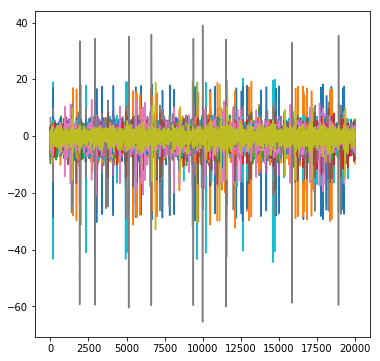

In [154]:
_ = plt.plot(data)

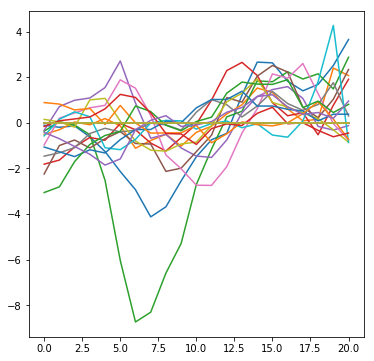

In [86]:
_ = plt.plot(waveform[0, :])

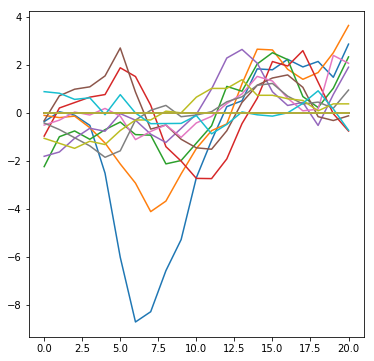

In [87]:
_ = plt.plot(waveform[1, :])

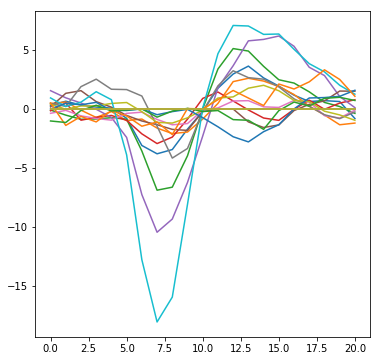

In [88]:
_ = plt.plot(waveform[2, :])

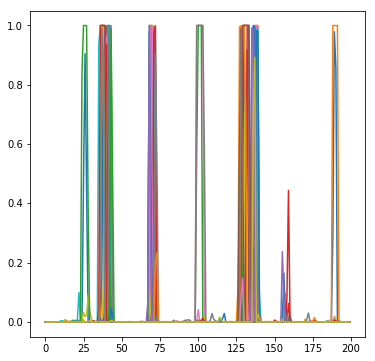

In [89]:
_ = plt.plot(proba)

## Triage predict

In [27]:
triager = NeuralNetTriage.load_from_file(triager_to_load,
                                         threshold=0.5)

In [32]:
# TODO: fix dimenstion mismatch in waveform outout
idx_clean = triager.predict(waveform[:, :, :7])

In [33]:
idx_clean

array([ True,  True, False, ...,  True, False, False])

## benchmark

In [24]:
# %%timeit
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)
output_names = ('spike_index', 'waveform', 'probability')
(spike_index,
 waveform,
 proba) = detector.predict(data, output_names=output_names)

triager = NeuralNetTriage(triager_to_load, threshold=0.5)

idx_clean = triager.predict(waveform[:, :, :7])

In [22]:
%%timeit
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)
# output_names = ('spike_index', 'waveform', 'probability')
# (spike_index,
#  waveform,
#  proba) = detector.predict(data, output_names=output_names)

triager = NeuralNetTriage(triager_to_load, detector, threshold=0.5)

idx_clean = triager.predict(data)

1.82 s ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## chaining

In [35]:
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)

triager = NeuralNetTriage(triager_to_load, threshold=0.5,
                          input_tensor=detector.waveform_tf[:, :, :7])

autoencoder = AutoEncoder(ae_to_load,
                          input_tensor=detector.waveform_tf)

In [36]:
import tensorflow as tf

out = (detector.spike_index_tf, triager.idx_clean, autoencoder.score_tf)

with tf.Session() as sess:
    detector.restore(sess)
    triager.restore(sess)
    autoencoder.restore(sess)
    
    spike_index_, idx_clean_, score_ = sess.run(out, feed_dict={detector.x_tf: data})

In [26]:
np.testing.assert_array_equal(spike_index, spike_index_)
np.testing.assert_array_equal(idx_clean, idx_clean_)